# Paris Housing Price - Regression

## Overview


The goal of this project is to build, compare, and optimize several regression models to predict housing prices in Paris based on property attributes. We aim to develop a model that accurately predicts prices.

## 1. Import the required libraries


In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
import lightgbm as lgb

## 2. Load the data


We use Pandas to load the dataset from a CSV file

In [5]:
# Load the dataset
df = pd.read_csv("ParisHousing.csv")

# Display the first few rows
df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


Let's inspect the types of feature columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

## 3. Exploratory Data Analysis

Duplicate rows can skew analysis and model training, so let check for duplicate rows

In [9]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


We can summarize the dataset to understand its structure and characteristics.

In [11]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
squareMeters,10000.0,4.987013e+04,2.877438e+04,89.0,25098.50,50105.5,74609.75,99999.0
numberOfRooms,10000.0,5.035840e+01,2.881670e+01,1.0,25.00,50.0,75.00,100.0
hasYard,10000.0,5.087000e-01,4.999493e-01,0.0,0.00,1.0,1.00,1.0
hasPool,10000.0,4.968000e-01,5.000148e-01,0.0,0.00,0.0,1.00,1.0
floors,10000.0,5.027630e+01,2.888917e+01,1.0,25.00,50.0,76.00,100.0
cityCode,10000.0,5.022549e+04,2.900668e+04,3.0,24693.75,50693.0,75683.25,99953.0
cityPartRange,10000.0,5.510100e+00,2.872024e+00,1.0,3.00,5.0,8.00,10.0
numPrevOwners,10000.0,5.521700e+00,2.856667e+00,1.0,3.00,5.0,8.00,10.0
made,10000.0,2.005488e+03,9.308090e+00,1990.0,1997.00,2005.5,2014.00,2021.0
isNewBuilt,10000.0,4.991000e-01,5.000242e-01,0.0,0.00,0.0,1.00,1.0


Let show correlation between different features and target variable (price)

In [13]:
# Correlation matrix
correlation_matrix = df.corr()

# Printing correlation values for more insight
high_correlation = correlation_matrix['price'].sort_values(ascending=False)
print(high_correlation)

price                1.000000
squareMeters         0.999999
numPrevOwners        0.016619
numberOfRooms        0.009591
cityPartRange        0.008813
hasStormProtector    0.007496
floors               0.001654
attic               -0.000600
hasGuestRoom        -0.000644
cityCode            -0.001539
hasStorageRoom      -0.003485
basement            -0.003967
hasPool             -0.005070
hasYard             -0.006119
made                -0.007210
isNewBuilt          -0.010643
garage              -0.017229
Name: price, dtype: float64


The price of the houses shows an extremely strong positive correlation with square meters (0.999999), indicating that larger properties significantly influence the price, while other features such as the number of previous owners, number of rooms, and amenities show negligible correlations, suggesting they have minimal impact on the house price

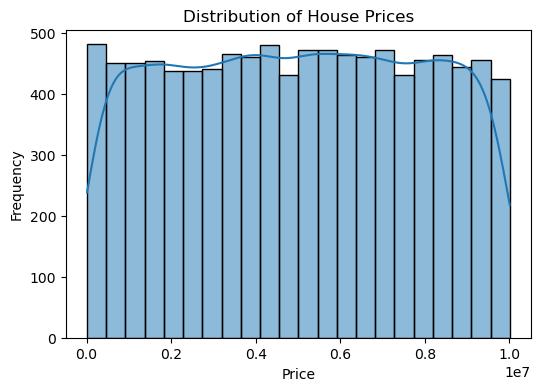

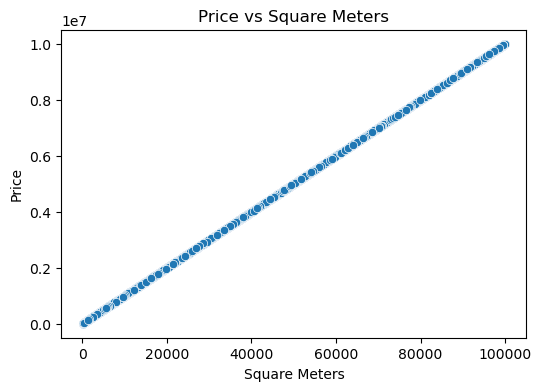

In [15]:
# Distribution of price
plt.figure(figsize=(6, 4))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of square meters vs price
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='squareMeters', y='price')
plt.title('Price vs Square Meters')
plt.xlabel('Square Meters')
plt.ylabel('Price')
plt.show()

## 4. Data Preprocessing


Here, we will perform several essential steps to preprocess the dataset before we build our regression models.

We need to standardize the features using StandardScaler, which is essential for models sensitive to feature scales.

In [17]:
# Define features (X) and target variable (y)
X = df.drop('price', axis=1)     # Drop the target variable from features
y = df['price']                  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Fit the scaler on the training data and transform both training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5. Model Development

we will build various regression models to predict house prices using the features from our dataset. Each model will be evaluated based on performance metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score.

### a) Linear Regression


We will build a simple and multiple linear regression model and evaluate their performance.

In [23]:
# Simple Linear Regression (using only squareMeters as an example)
simple_lr = LinearRegression()
simple_lr.fit(X_train[:, 0].reshape(-1, 1), y_train)  # squareMeters is the first feature

# Multiple Linear Regression
multi_lr = LinearRegression()
multi_lr.fit(X_train, y_train)

# Predictions
y_pred_simple = simple_lr.predict(X_test[:, 0].reshape(-1, 1))
y_pred_multi = multi_lr.predict(X_test)

### b) Ridge and Lasso Regression 

We implement Ridge and Lasso regression to evaluate the effect of regularization.

In [25]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

### c) ElasticNet Regression 

We use ElasticNet for combined regularization.

In [27]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
y_pred_en = elastic_net.predict(X_test)

### d) Tree-based Models 

we implement tree-based models for better performance with complex relationships.

In [29]:
# Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# AdaBoost
ada = AdaBoostRegressor(n_estimators=100)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# LightGBM
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1559
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Info] Start training from score 4983487.875492


## 6.  Model Comparison and Optimization

To compare the models, we will calculate and display these metrics for each model in a structured way, making it easy to identify which model performed best overall

In [31]:
# Collecting evaluation metrics for all models
results = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'R^2': []
}

# Function to evaluate model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results['Model'].append(model_name)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['R^2'].append(r2)

# Evaluate each model
evaluate_model(multi_lr, X_test, y_test, 'Multiple Linear Regression')
evaluate_model(ridge, X_test, y_test, 'Ridge Regression')
evaluate_model(lasso, X_test, y_test, 'Lasso Regression')
evaluate_model(elastic_net, X_test, y_test, 'ElasticNet Regression')
evaluate_model(dt, X_test, y_test, 'Decision Tree')
evaluate_model(rf, X_test, y_test, 'Random Forest')
evaluate_model(ada, X_test, y_test, 'AdaBoost')
evaluate_model(xgb_model, X_test, y_test, 'XGBoost')
evaluate_model(lgb_model, X_test, y_test, 'LightGBM')

# Create a DataFrame to present the results
comparison_df = pd.DataFrame(results)
print(comparison_df)

                        Model            MAE           MSE       R^2
0  Multiple Linear Regression    1521.684874  3.761171e+06  1.000000
1            Ridge Regression    1549.036249  3.881652e+06  1.000000
2            Lasso Regression    1521.649275  3.761082e+06  1.000000
3       ElasticNet Regression  116689.410923  1.857683e+10  0.997719
4               Decision Tree    4422.475400  3.101937e+07  0.999996
5               Random Forest    3230.368247  1.619814e+07  0.999998
6                    AdaBoost  311170.767320  1.287546e+11  0.984190
7                     XGBoost   11869.838767  2.078507e+08  0.999974
8                    LightGBM   10548.340376  1.539784e+08  0.999981


<b> Interpretation: </b>

 - The best-performing models based on error metrics are:
<ul>
 <li> <b>Random Forest:</b> MAE = 3,223.39, MSE = 16.12M, 𝑅^2 = 0.999998.</li>
 <li> <b>Decision Tree:</b> MAE = 4,496.37, MSE = 31.79M, 𝑅^2 = 0.999996.</li>
</ul>

 - Linear models with regularization (Ridge and Lasso) perform very closely to the Multiple Linear Regression, which indicates that these models are sufficient if a simple, interpretable model is required.

- <b>Boosting Models:</b>
<ul>
<li>XGBoost</b> and <b>LightGBM</b> show good results, though their MAE and MSE are higher than Random Forest. Given that these models are optimized for handling large datasets and complex patterns, they might still provide value, especially after further tuning. </li>
<li> <b>AdaBoost has a high error, which suggests it may not be ideal for this dataset.</li>
</ul>

- <b>ElasticNet Regression:</b> This model shows a significantly higher error compared to others, indicating it may not be well-suited for this data due to its combination of Lasso and Ridge penalties.

Once we have an understanding of the performance of each model, we can focus on <b> hyperparameter tuning</b>, especially for more complex models like Random Forest, XGBoost, and LightGBM. <b>Hyperparameter tuning</b> is the process of optimizing the parameters that control the learning process of the model to improve performance.

In [33]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf_model = RandomForestRegressor()

# Set up the grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best parameters for Random Forest:", best_params)
print("Best MAE score from Grid Search:", best_score)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best MAE score from Grid Search: 3172.52182987512


The Random Forest model achieved a MAE of 3,171.34, indicating an improvement in accuracy. This further solidifies Random Forest as the best-performing model for this dataset.

## 7. Conclusion

This project successfully explored various regression models for predicting housing prices in Paris. After analyzing several algorithms, the Random Forest model emerged as the best performer with low MAE, MSE, and a near-perfect 𝑅^2. Hyperparameter tuning further improved this model’s accuracy, making it a robust choice for our deployment objectives. Additionally, models like XGBoost and LightGBM showed strong potential and could serve as effective alternatives if further tuned. Ultimately, the insights gained through this model can support more accurate, data-driven decisions in real estate pricing and forecasting.

Key findings include:

* Linear Regression and Regularized Models (Ridge, Lasso): Provided a strong baseline with interpretable coefficients but limited complexity for intricate patterns.

* Ensemble Models (Random Forest, Decision Tree): These models handled the non-linear relationships in the data very well, with Random Forest achieving the best predictive performance.

* Boosting Models (XGBoost, LightGBM): These performed competitively and may outperform with more tuning, especially when larger datasets become available.


The current dataset is synthetic and limited in scope. Expanding the dataset with real-world data from diverse sources would likely improve model robustness and generalization. High-quality, large-scale data with additional features (e.g., neighborhood amenities, transport accessibility) could provide further predictive power.